In [1]:
# env: esm1
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model.eval().to(device)

Using device: cuda


SyntaxError: invalid syntax (77354199.py, line 1)

In [3]:
# Check for duplicate rows in tb_df
duplicate_rows = tb_df[tb_df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
if not duplicate_rows.empty:
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

# Alternatively, check for duplicate sequences specifically
duplicate_sequences = tb_df[tb_df.duplicated(subset="Sequences")]
print("Number of duplicate sequences:", duplicate_sequences.shape[0])
if not duplicate_sequences.empty:
    print(duplicate_sequences)
else:
    print("No duplicate sequences found.")

NameError: name 'tb_df' is not defined

## spatial plot

In [5]:

# Load ESM-1b model and alphabet
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval().cuda()  # Use GPU if available

# Example: sequences to embed
# Replace this with your DataFrame or sequence list
# df = pd.read_csv("your_sequences.csv")
# sequences = df["Sequences"].tolist()
sequences = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models/generated_peptides.fasta", "fasta")]

# Prepare data: ESM expects list of (name, sequence) tuples
data = [(f"seq{i}", seq) for i, seq in enumerate(sequences)]

# Batch encode and extract embeddings
all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(data), 8)):  # small batches if memory constrained
        batch_data = data[i:i+8]
        labels, strs, tokens = batch_converter(batch_data)
        tokens = tokens.cuda()

        # Extract representations from the final layer
        results = model(tokens, repr_layers=[33], return_contacts=False)
        token_representations = results["representations"][33]

        for j, (_, seq) in enumerate(batch_data):
            # Extract per-sequence embedding: mean of all token embeddings (excluding special tokens)
            emb = token_representations[j, 1:len(seq)+1].mean(0)  # shape: (1280,)
            all_embeddings.append(emb.cpu().numpy())

# Convert to DataFrame
embedding_df = pd.DataFrame(all_embeddings)
embedding_df["sequence"] = sequences

# Save if needed
# embedding_df.to_csv("esm1b_embeddings.csv", index=False)

print("✅ ESM-1b embeddings generated and saved.")


100%|██████████| 13/13 [00:01<00:00, 11.53it/s]

✅ ESM-1b embeddings generated and saved.


100%|██████████| 38/38 [03:27<00:00,  5.45s/it]


Explained variance by first 50 components: 0.92


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


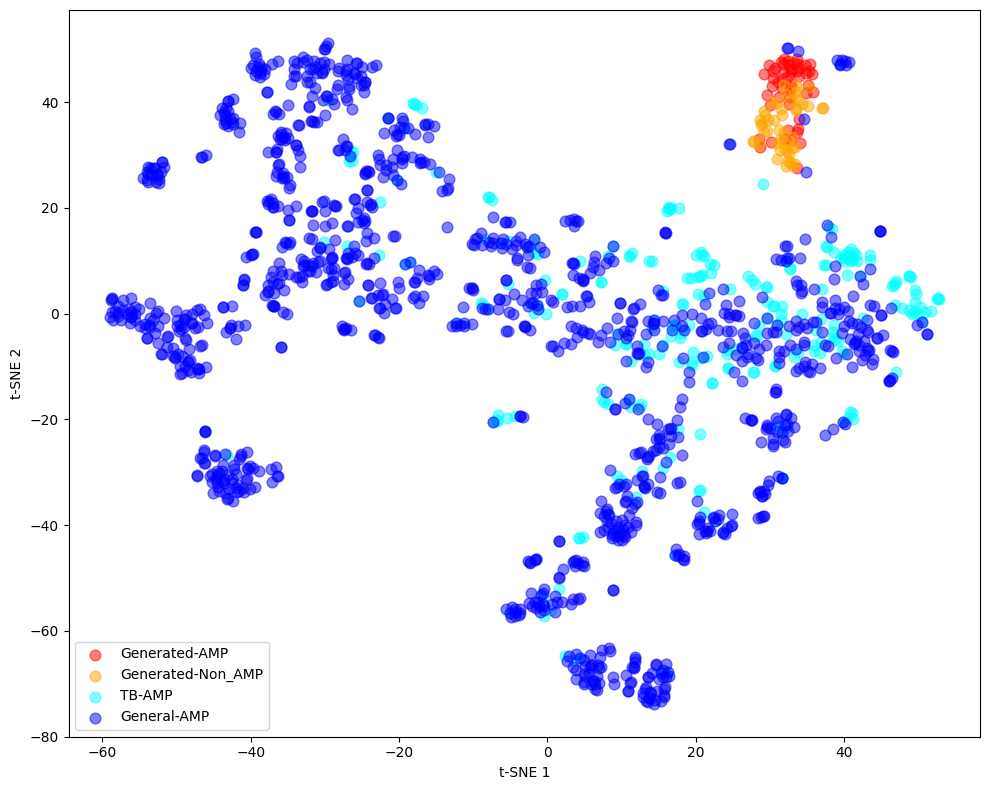

In [ ]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/generated_peptides-notrans.fasta", "fasta")]
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences, "Generated-AMP")

generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models/1745346340796_AMPCandidates0.7-neg.fa", "fasta")]
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences, "Generated-Non_AMP")


# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv")
ref_df = ref_df.drop_duplicates(subset='Sequences')

df_filtered = ref_df

def split_sequence(seq, chunk_size=20):
    return [seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size)]

new_rows = []
for _, row in df_filtered.iterrows():
    seq = row['Sequences']
    amp_label = row['AMP']
    if len(seq) > 40:
        for chunk in split_sequence(seq, 20):
            new_rows.append({'Sequences': chunk, 'AMP': amp_label})
    else:
        new_rows.append({'Sequences': seq, 'AMP': amp_label})

df_filtered = pd.DataFrame(new_rows)
ref_df = df_filtered
ref_df = ref_df[
    (ref_df['Sequences'].str.len() >= 10) &
    (ref_df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df['Sequences'].str.contains('X'))
]
ref_df = ref_df.loc[ref_df['AMP'] == 1, :]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

################

adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_df = adam_df[~adam_df['Sequences'].isin(ref_df['Sequences'])]
filtered_adam_df = adam_df[
    (adam_df['Sequences'].str.len() >= 10) &
    (adam_df['Sequences'].str.len() <= 40)
].reset_index(drop=True)

adam_df = filtered_adam_df[:1200]
reference_sequences = adam_df["Sequences"].tolist()
general_embeddings, general_labels = extract_esm_embeddings(reference_sequences, "General-AMP")


# Combine and reduce
all_embeddings = gen_embeddings_pos + gen_embeddings_neg +ref_embeddings + general_embeddings
all_labels = gen_labels_pos + gen_labels_neg +ref_labels + general_labels

pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

# Calculate how much variance is explained by the first 50 components
explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")
# Apply t-SNE on the PCA result
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Plot using matplotlib
vis_df = pd.DataFrame(tsne, columns=["x", "y"])
vis_df["Source"] = all_labels

colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan",
    "General-AMP": "blue"
}
plt.figure(figsize=(10, 8))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.5, s=60, c=colors[label])

# plt.title("t-SNE of ESM-1b Embeddings: Generated vs Reference AMPs")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


### working version

100%|██████████| 38/38 [03:49<00:00,  6.05s/it]


Explained variance by first 50 components: 0.95


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


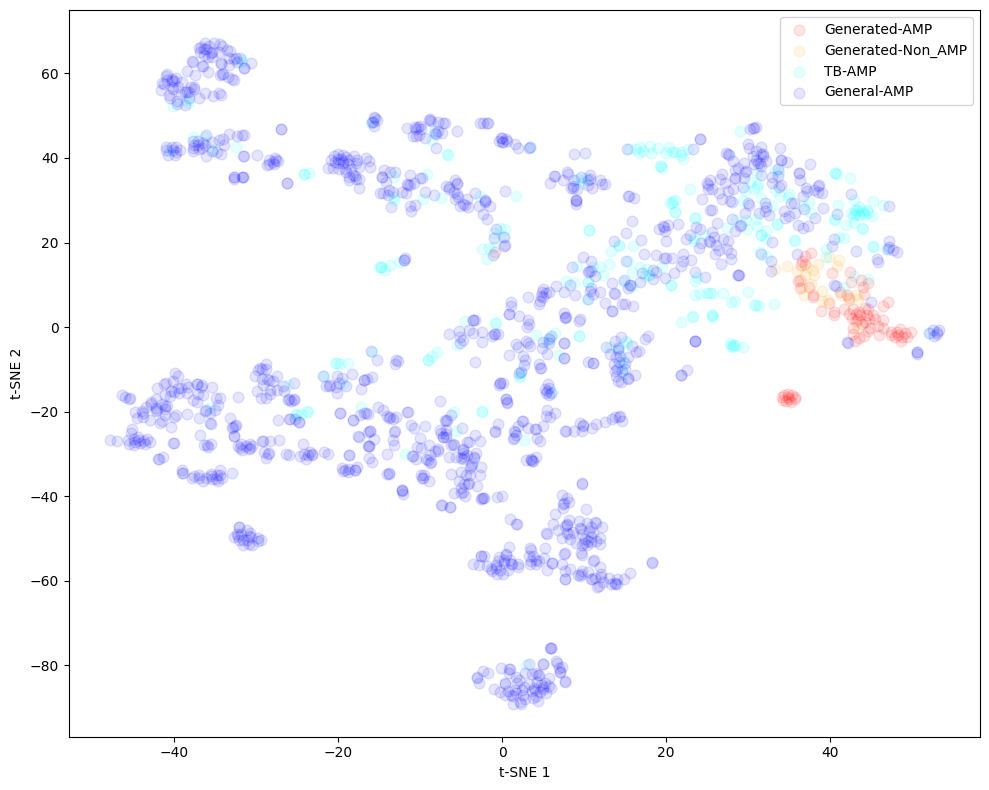

In [3]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences, "Generated-AMP")

generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences, "Generated-Non_AMP")


# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv")
ref_df = ref_df.drop_duplicates(subset='Sequences')

df_filtered = ref_df

def split_sequence(seq, chunk_size=20):
    return [seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size)]

new_rows = []
for _, row in df_filtered.iterrows():
    seq = row['Sequences']
    amp_label = row['AMP']
    if len(seq) > 40:
        for chunk in split_sequence(seq, 20):
            new_rows.append({'Sequences': chunk, 'AMP': amp_label})
    else:
        new_rows.append({'Sequences': seq, 'AMP': amp_label})

df_filtered = pd.DataFrame(new_rows)
ref_df = df_filtered
ref_df = ref_df[
    (ref_df['Sequences'].str.len() >= 10) &
    (ref_df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df['Sequences'].str.contains('X'))
]
ref_df = ref_df.loc[ref_df['AMP'] == 1, :]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

################

adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_df = adam_df[~adam_df['Sequences'].isin(ref_df['Sequences'])]
filtered_adam_df = adam_df[
    (adam_df['Sequences'].str.len() >= 10) &
    (adam_df['Sequences'].str.len() <= 40)
].reset_index(drop=True)

adam_df = filtered_adam_df[:1200]
reference_sequences = adam_df["Sequences"].tolist()
general_embeddings, general_labels = extract_esm_embeddings(reference_sequences, "General-AMP")


# Combine and reduce
all_embeddings = gen_embeddings_pos + gen_embeddings_neg +ref_embeddings + general_embeddings
all_labels = gen_labels_pos + gen_labels_neg +ref_labels + general_labels

pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

# Calculate how much variance is explained by the first 50 components
explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")
# Apply t-SNE on the PCA result
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Plot using matplotlib
vis_df = pd.DataFrame(tsne, columns=["x", "y"])
vis_df["Source"] = all_labels

colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan",
    "General-AMP": "blue"
}
plt.figure(figsize=(10, 8))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.1, s=60, c=colors[label])

# plt.title("t-SNE of ESM-1b Embeddings: Generated vs Reference AMPs")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
print(pd.Series(aps_sequences).isna().sum())

0


### all overlap - esm1b

100%|██████████| 731/731 [1:16:43<00:00,  6.30s/it]


Explained variance by first 50 components: 0.94


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


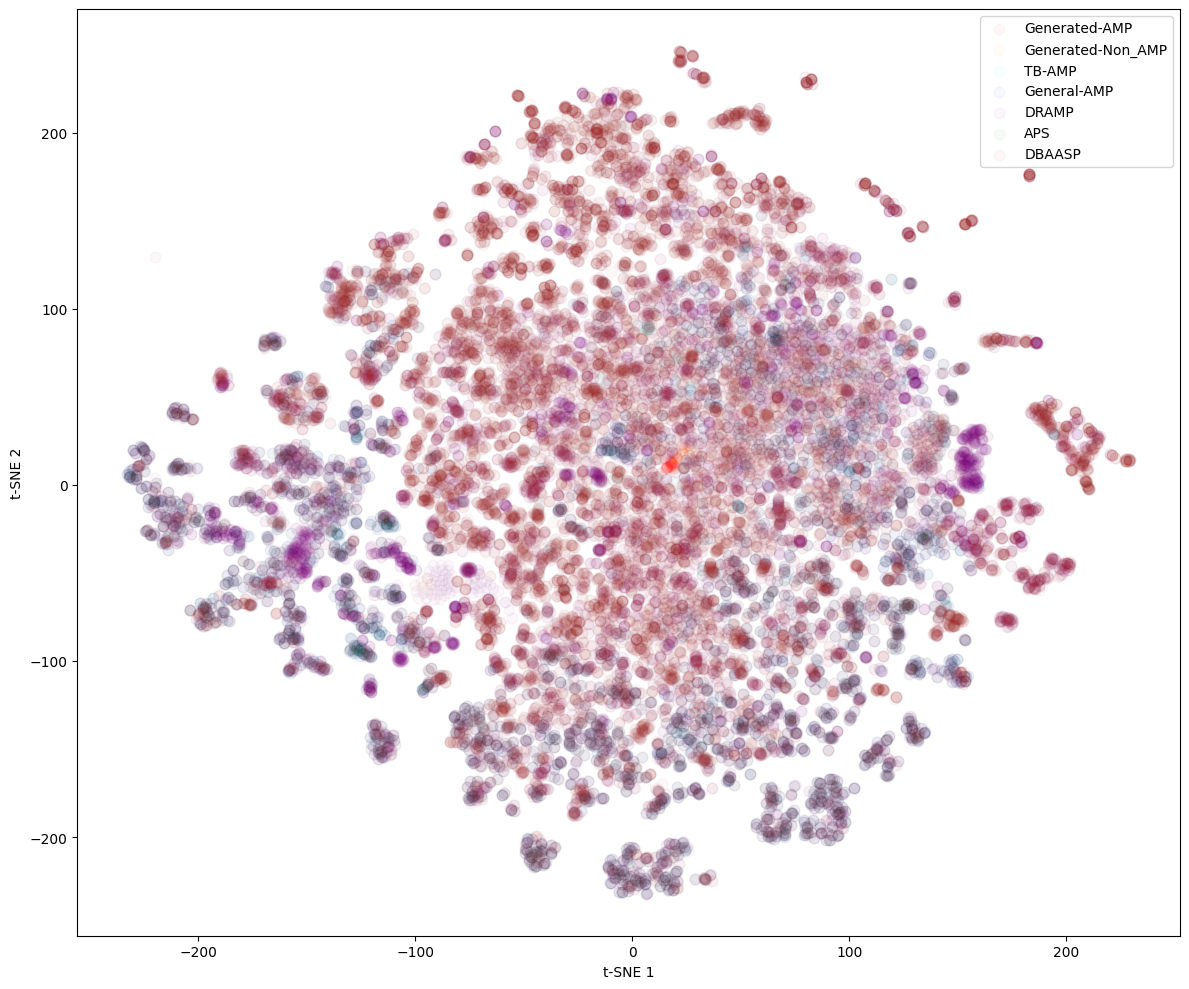

In [5]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

# General AMP sequences from ADAM
adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_sequences = adam_df['Sequences'].str[:1200].tolist()
general_embeddings, general_labels = extract_esm_embeddings(adam_sequences, "General-AMP")

# DRAMP sequences
dramps_df = pd.read_csv("./database_check/dramps_general_amps.txt", sep='\t')
dramps_sequences = dramps_df['Sequence'].dropna().tolist()
dramps_embeddings, dramps_labels = extract_esm_embeddings(dramps_sequences, "DRAMP")

# APS sequences
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
aps_embeddings, aps_labels = extract_esm_embeddings(aps_sequences, "APS")

# DBAASP sequences
dbbasp_df = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp_sequences = dbbasp_df['SEQUENCE'].dropna().tolist()
dbbasp_embeddings, dbbasp_labels = extract_esm_embeddings(dbbasp_sequences, "DBAASP")

# Combine embeddings
all_embeddings = (gen_embeddings_pos + gen_embeddings_neg + ref_embeddings + general_embeddings +
                  dramps_embeddings + aps_embeddings + dbbasp_embeddings)

all_labels = (gen_labels_pos + gen_labels_neg + ref_labels + general_labels +
              dramps_labels + aps_labels + dbbasp_labels)

all_embeddings = np.array(all_embeddings)
# Find indices without NaNs
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
# Filter embeddings and labels to remove NaN-containing entries
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Plot results
colors = {
    "Generated-AMP": "red", "Generated-Non_AMP": "orange", "TB-AMP": "cyan", "General-AMP": "blue",
    "DRAMP": "purple", "APS": "green", "DBAASP": "brown"
}

plt.figure(figsize=(12, 10))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.03, s=60, c=colors[label])

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


### separate plots - esm1b

100%|██████████| 366/366 [1:17:15<00:00, 12.67s/it]


Explained variance by first 50 components: 0.94


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


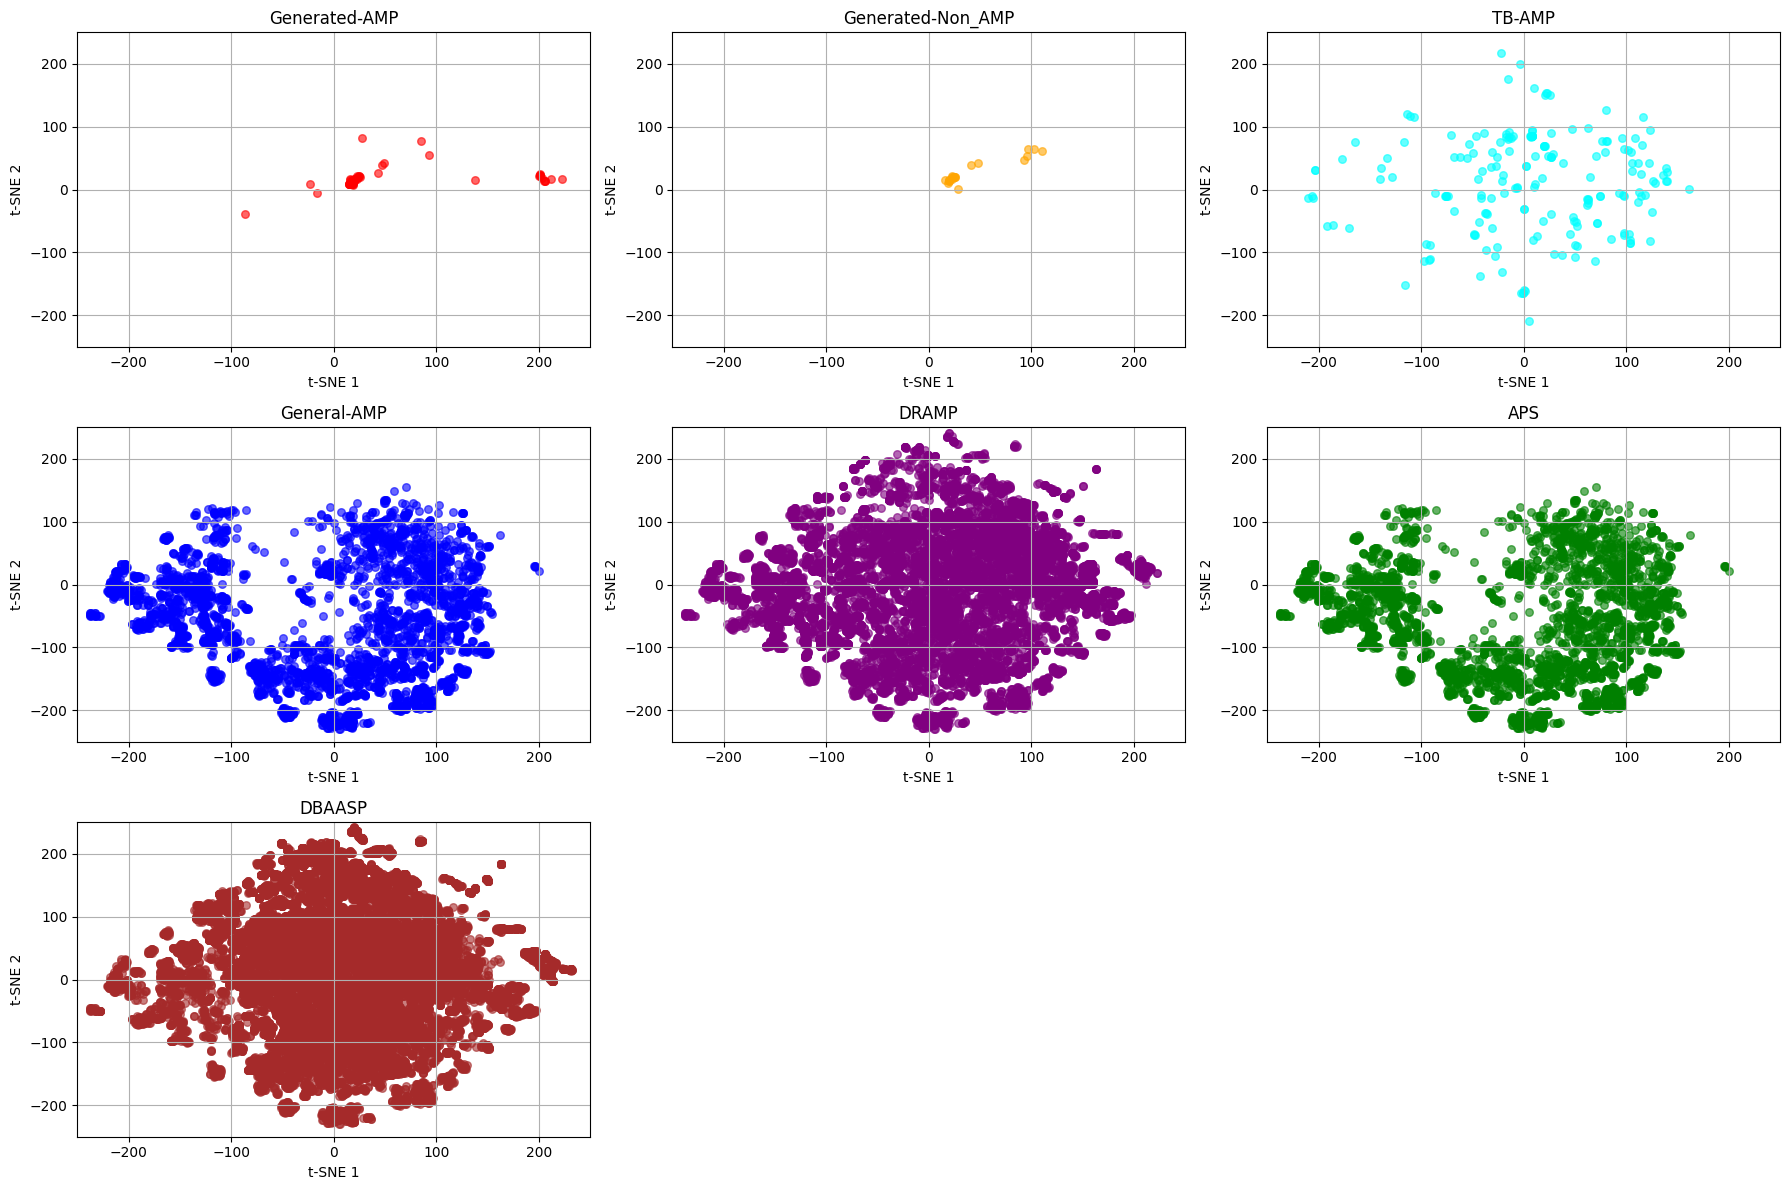

In [6]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=64):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

# General AMP sequences from ADAM
adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_sequences = adam_df['Sequences'].str[:1200].tolist()
general_embeddings, general_labels = extract_esm_embeddings(adam_sequences, "General-AMP")

# DRAMP sequences
dramps_df = pd.read_csv("./database_check/dramps_general_amps.txt", sep='\t')
dramps_sequences = dramps_df['Sequence'].dropna().tolist()
dramps_embeddings, dramps_labels = extract_esm_embeddings(dramps_sequences, "DRAMP")

# APS sequences
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
aps_embeddings, aps_labels = extract_esm_embeddings(aps_sequences, "APS")

# DBAASP sequences
dbbasp_df = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp_sequences = dbbasp_df['SEQUENCE'].dropna().tolist()
dbbasp_embeddings, dbbasp_labels = extract_esm_embeddings(dbbasp_sequences, "DBAASP")

# Combine embeddings
all_embeddings = (gen_embeddings_pos + gen_embeddings_neg + ref_embeddings + general_embeddings +
                  dramps_embeddings + aps_embeddings + dbbasp_embeddings)

all_labels = (gen_labels_pos + gen_labels_neg + ref_labels + general_labels +
              dramps_labels + aps_labels + dbbasp_labels)

all_embeddings = np.array(all_embeddings)
# Find indices without NaNs
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
# Filter embeddings and labels to remove NaN-containing entries
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Plot results
colors = {
    "Generated-AMP": "red", "Generated-Non_AMP": "orange", "TB-AMP": "cyan", "General-AMP": "blue",
    "DRAMP": "purple", "APS": "green", "DBAASP": "brown"
}

# Plot each set separately with same axis range
plt.figure(figsize=(18, 12))
unique_labels = vis_df["Source"].unique()

for i, label in enumerate(unique_labels, 1):
    subset = vis_df[vis_df["Source"] == label]
    plt.subplot(3, 3, i)  # Adjust rows/columns as needed for layout
    plt.scatter(subset["x"], subset["y"], alpha=0.6, s=30, c=colors[label], label=label)
    plt.title(label)
    plt.xlim(-250, 250)
    plt.ylim(-250, 250)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)

plt.tight_layout()
plt.show()

### ref+gen - esm1b

100%|██████████| 4/4 [00:59<00:00, 14.79s/it]


Explained variance by first 50 components: 0.98


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


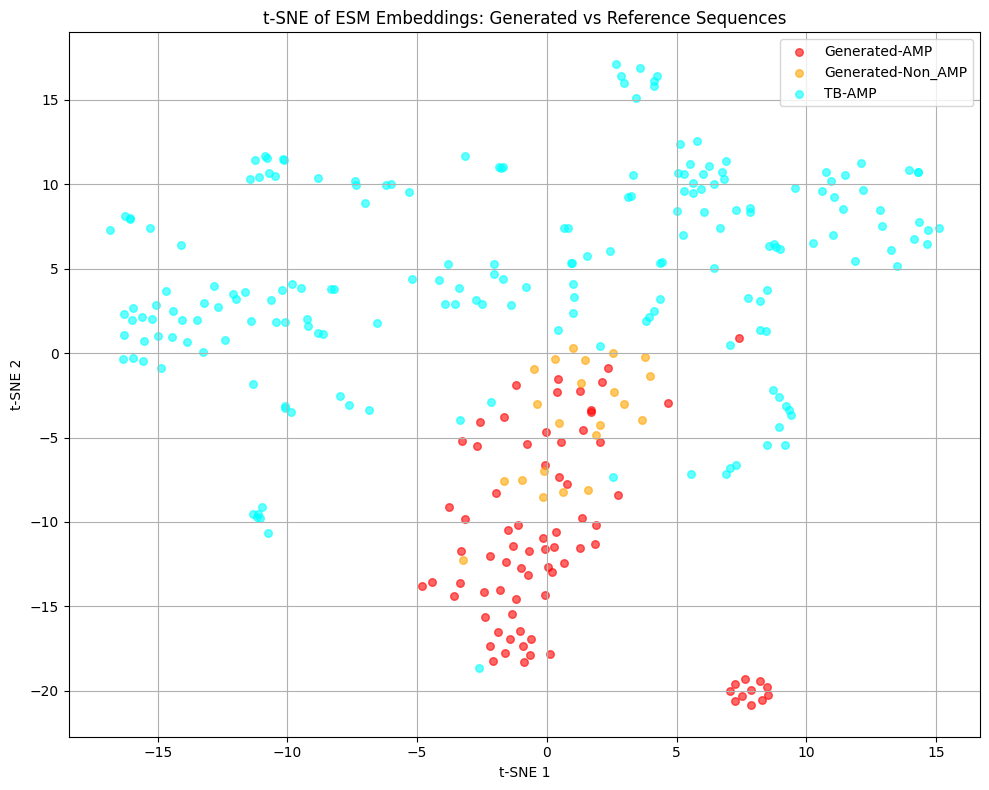

In [3]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=64):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

# Combine only relevant groups
all_embeddings = gen_embeddings_pos + gen_embeddings_neg + ref_embeddings
all_labels = gen_labels_pos + gen_labels_neg + ref_labels

# Remove any NaN-containing entries
all_embeddings = np.array(all_embeddings)
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)
print(f"Explained variance by first 50 components: {np.sum(pca_model.explained_variance_ratio_):.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Create dataframe for visualization
vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Define colors
colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan"
}

# Filter to only include selected labels for plotting
plot_labels = ["Generated-AMP", "Generated-Non_AMP", "TB-AMP"]
vis_subset = vis_df[vis_df["Source"].isin(plot_labels)]

# Plotting
plt.figure(figsize=(10, 8))
for label in plot_labels:
    subset = vis_subset[vis_subset["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.6, s=30, c=colors[label])

plt.title("t-SNE of ESM Embeddings: Generated vs Reference Sequences")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
# plt.xlim(-250, 250)
# plt.ylim(-250, 250)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ref+gen - esm1v

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1v_t33_650M_UR90S_1.pt" to /mnt/storageG1//lwang/.cache/torch/hub/checkpoints/esm1v_t33_650M_UR90S_1.pt
/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
100%|██████████| 4/4 [00:48<00:00, 12.05s/it]


Explained variance by first 50 components: 0.95


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


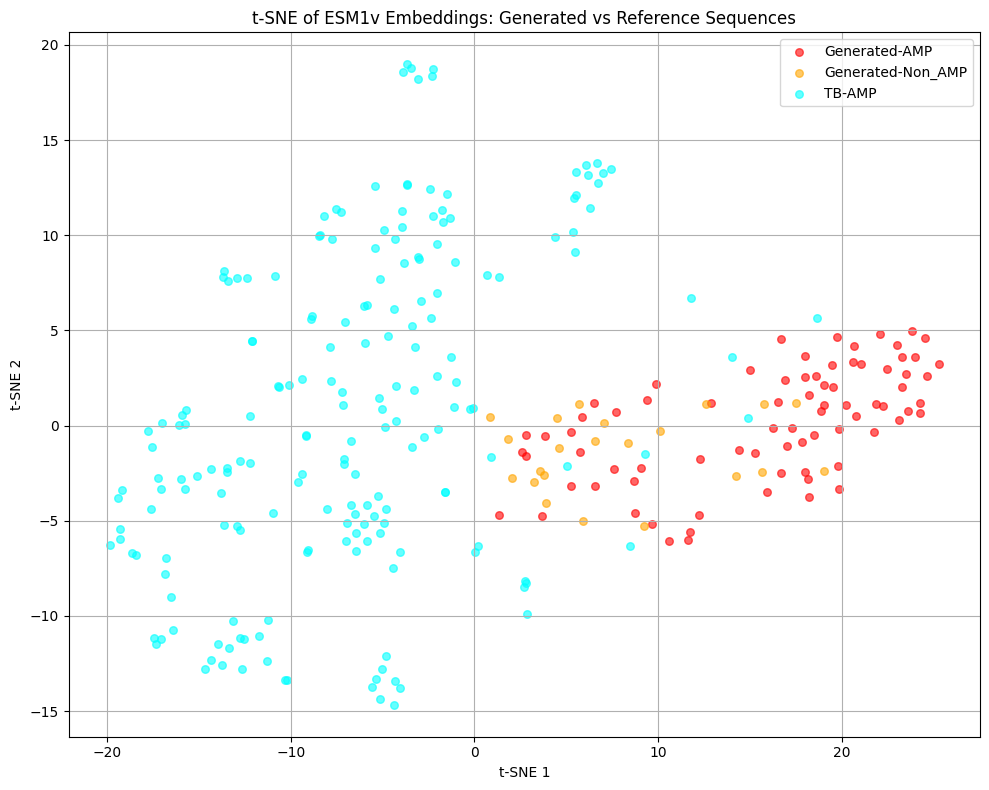

In [5]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM1v model
# model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S()  # Updated to ESM1v model
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm1v_embeddings(sequence_list, label_prefix, batch_size=64):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]  # Penultimate layer output

            for j, (_, seq) in enumerate(batch_data):
                # Global average pooling across residues (excluding BOS and EOS tokens)
                emb = token_representations[j, 1:len(seq)+1].mean(dim=0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings from ESM1v
gen_embeddings_pos, gen_labels_pos = extract_esm1v_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm1v_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm1v_embeddings(reference_sequences, "TB-AMP")

# Combine only selected groups
all_embeddings = gen_embeddings_pos + gen_embeddings_neg + ref_embeddings
all_labels = gen_labels_pos + gen_labels_neg + ref_labels

# Remove any NaN-containing entries
all_embeddings = np.array(all_embeddings)
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)
print(f"Explained variance by first 50 components: {np.sum(pca_model.explained_variance_ratio_):.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Create dataframe for visualization
vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Define colors
colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan"
}

# Filter to only include selected labels for plotting
plot_labels = ["Generated-AMP", "Generated-Non_AMP", "TB-AMP"]
vis_subset = vis_df[vis_df["Source"].isin(plot_labels)]

# Plotting
plt.figure(figsize=(10, 8))
for label in plot_labels:
    subset = vis_subset[vis_subset["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.6, s=30, c=colors[label])

plt.title("t-SNE of ESM1v Embeddings: Generated vs Reference Sequences")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ref+gen - esm2

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /mnt/storageG1//lwang/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /mnt/storageG1//lwang/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
100%|██████████| 4/4 [01:50<00:00, 27.58s/it]


Explained variance by first 50 components: 0.95


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


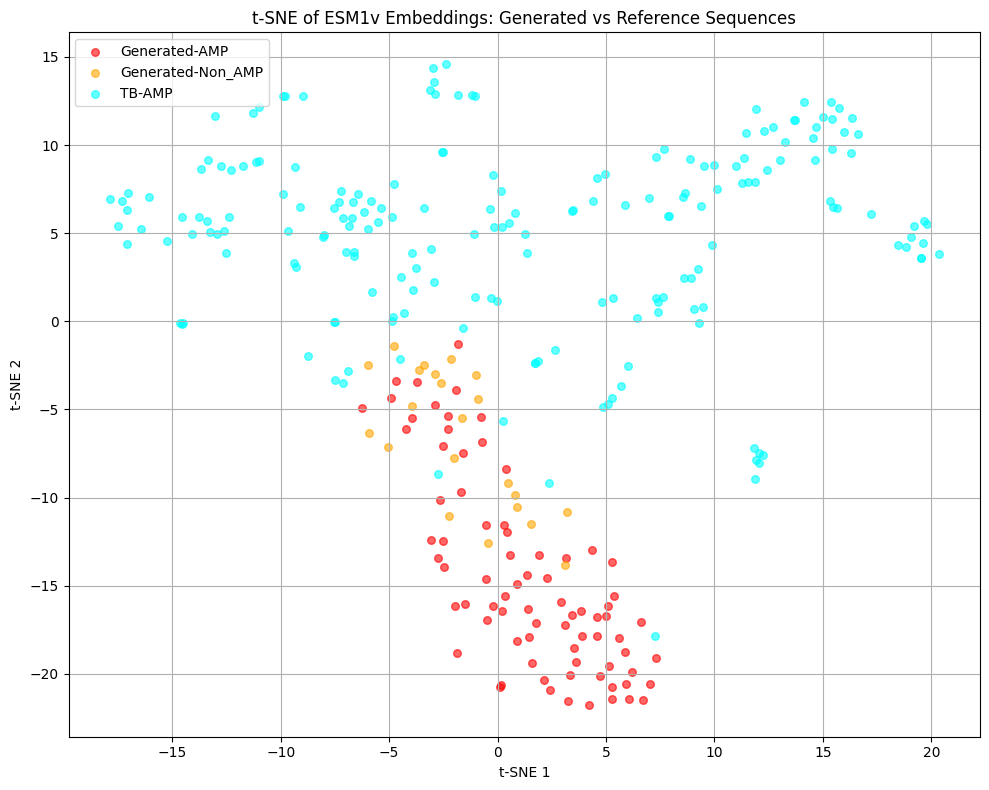

In [6]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM1v model
# model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Updated to ESM1v model
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm1v_embeddings(sequence_list, label_prefix, batch_size=64):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]  # Penultimate layer output

            for j, (_, seq) in enumerate(batch_data):
                # Global average pooling across residues (excluding BOS and EOS tokens)
                emb = token_representations[j, 1:len(seq)+1].mean(dim=0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings from ESM1v
gen_embeddings_pos, gen_labels_pos = extract_esm1v_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm1v_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm1v_embeddings(reference_sequences, "TB-AMP")

# Combine only selected groups
all_embeddings = gen_embeddings_pos + gen_embeddings_neg + ref_embeddings
all_labels = gen_labels_pos + gen_labels_neg + ref_labels

# Remove any NaN-containing entries
all_embeddings = np.array(all_embeddings)
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)
print(f"Explained variance by first 50 components: {np.sum(pca_model.explained_variance_ratio_):.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Create dataframe for visualization
vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Define colors
colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan"
}

# Filter to only include selected labels for plotting
plot_labels = ["Generated-AMP", "Generated-Non_AMP", "TB-AMP"]
vis_subset = vis_df[vis_df["Source"].isin(plot_labels)]

# Plotting
plt.figure(figsize=(10, 8))
for label in plot_labels:
    subset = vis_subset[vis_subset["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.6, s=30, c=colors[label])

plt.title("t-SNE of ESM1v Embeddings: Generated vs Reference Sequences")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import esm

available_models = list(esm.pretrained.__dict__.keys())
for model in available_models:
    if model.startswith("esm"):
        print(model)


esm
esm1_t34_670M_UR50S
esm1_t34_670M_UR50D
esm1_t34_670M_UR100
esm1_t12_85M_UR50S
esm1_t6_43M_UR50S
esm1b_t33_650M_UR50S
esm_msa1_t12_100M_UR50S
esm_msa1b_t12_100M_UR50S
esm1v_t33_650M_UR90S
esm1v_t33_650M_UR90S_1
esm1v_t33_650M_UR90S_2
esm1v_t33_650M_UR90S_3
esm1v_t33_650M_UR90S_4
esm1v_t33_650M_UR90S_5
esm_if1_gvp4_t16_142M_UR50
esm2_t6_8M_UR50D
esm2_t12_35M_UR50D
esm2_t30_150M_UR50D
esm2_t33_650M_UR50D
esm2_t36_3B_UR50D
esm2_t48_15B_UR50D
esmfold_v0
esmfold_v1
esmfold_structure_module_only_8M
esmfold_structure_module_only_8M_270K
esmfold_structure_module_only_35M
esmfold_structure_module_only_35M_270K
esmfold_structure_module_only_150M
esmfold_structure_module_only_150M_270K
esmfold_structure_module_only_650M
esmfold_structure_module_only_650M_270K
esmfold_structure_module_only_3B
esmfold_structure_module_only_3B_270K
esmfold_structure_module_only_15B


## presence of AMP

In [ ]:
from Bio import SeqIO

def read_fasta_sequences(fasta_path):
    """
    Reads sequences from a FASTA file and returns them as a list of strings.

    Args:
        fasta_path (str): Path to the FASTA file.

    Returns:
        List[str]: A list of amino acid or nucleotide sequences as strings.
    """
    sequences = [str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
    return sequences
generated = read_fasta_sequences("1745419634972_AMPCandidates-pos-nontox.fa") # transfer learning outputs
# generated = read_fasta_sequences("1745429455143_AMPCandidates-pos-nontox.fa") # no transfer learning outputs
print(len(generated))

74


DRAMP

In [7]:
dramps = pd.read_csv("./database_check/dramps_general_amps.txt", sep = '\t')
dramps['Sequence']

0                           SLGPAIKATRQVCPKATRFVTVSCKKSDCQ
1                                 VTSWSLCTPGCTSPGGGSNCSFCC
2                                 GNGVLKTISHECNMNTWQFLFTCC
3                                    SSSGWLCTLTIECGTIICACR
4        MSWLNFLKYIAKYGKKAVSAAWKYKGKVLEWLNVGPTLEWVWQKLK...
                               ...                        
11607                                          LLLLLLLLLLL
11608                              LLLLLLLLLLLLLLLLLLLLLLL
11609                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
11610                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
11611                                   GAGIVVASIDTGVRVSHE
Name: Sequence, Length: 11612, dtype: object

In [8]:
# Create a set of sequences from dramps for faster lookup
dramps_set = set(dramps['Sequence'])

# Filter out sequences in generated that are present in dramps_set
generated = [seq for seq in generated if seq not in dramps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 74


APS

In [9]:
aps = read_fasta_sequences("./database_check/aps.fasta")


In [10]:
aps_set = set(aps)

generated = [seq for seq in generated if seq not in aps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 74


DBBASP

In [11]:
dbbasp = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp['SEQUENCE']

0        NLVSGLIEARKYLEQLHRKLKNCKV    ENREVPPGFTALIKTLR...
1                    WLNALLHHGLNCAKGVLA    ALLHHGLNCAKGVLA
2                   KWLNALLHHGLNCAKGVLA    ALLHHGLNCAKGVLA
3        SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG    IA...
4        XTCASRCPRPCNAGLCCSIYGYCGSGNAYCGAGNCRCQCRG    X...
                               ...                        
23358                                                  Rxr
23359                                                  RxR
23360                                                  rXr
23361                                                  RXr
23362                                                  rxR
Name: SEQUENCE, Length: 23363, dtype: object

In [12]:
aps_set = set(dbbasp['SEQUENCE'])

generated = [seq for seq in generated if seq not in aps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 74


Uniprot

In [13]:
import requests

def check_uniprot(peptide):
    url = f"https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"sequence:{peptide}",
        "format": "json",
        "fields": "accession,id,sequence"
    }
    response = requests.get(url, params=params)
    results = response.json()
    return results.get("results", [])

# Example usage
peptides = generated
for pep in peptides:
    hits = check_uniprot(pep)
    print(f"{pep}: {'✅ Found' if hits else '❌ Not found'}")


KAAYYPHGKKGKGPHKHKKG: ❌ Not found
IHWTKYGGGHKHKKHKGKGYKGDKKKKGKGPKKGKKKKP: ❌ Not found
IAKPKPKKKEGGKHKPHKK: ❌ Not found
FAAAYPKPMGPK: ❌ Not found
EQAAGKPPAKKHGKYKKKKYYHKHHG: ❌ Not found
VAADYGGKYHKKHKKKKKGK: ❌ Not found
DAAKKAKGKGKKYG: ❌ Not found
QAKVVPKGGPKDGK: ❌ Not found
CAGLKGKHHK: ❌ Not found
AMIKAHHHYKPKKKKKGKHG: ❌ Not found
DAWYYHAYKYYPHKPKGKYK: ❌ Not found
HAHYDKRKKKKHKKPPKKKK: ❌ Not found
TAAIKKKYKHKHKGGYKKKG: ❌ Not found
YAGMKHYKKKKH: ❌ Not found
AGAAAAPKKGKKGKK: ❌ Not found
VAAGKKPKGGKGKYKKKKKY: ❌ Not found
VARPPHGKPYKKKKYPKKKG: ❌ Not found
QAPEVHATGHYYKKKHKKKKKGKGKKPKGGKKGG: ❌ Not found
RAAAAGKKKYKHPHYDYGPK: ❌ Not found
WAGYKKKKKKPGHYPKKHGKKKGYYKKIKKGPKYKKKYPG: ❌ Not found
AAAASPYYKKYPHKGYKHK: ❌ Not found
GAAKKPKPKKPKGGKKKHGD: ❌ Not found
QAAGWHKMKKPYGTK: ❌ Not found
MAYHGKGGGGGGK: ❌ Not found
HAAPPGGKKKKKKGHKPKKGKKHHKGKHKGPKKKK: ❌ Not found
EAAADGGGHGPGKKYGKYPKHGKSKKHKGKKKHGKHKGK: ❌ Not found
DAAAAYHPHKKKKKKVKYGK: ❌ Not found
PAAPKPGPGGGKKKKPKKKKKHKKHPKKPKGYKKGK: ❌ Not fo

### scanner outputs

In [7]:
# scanner = pd.read_csv("./1745419634972_results/1745419634972_Prediction_Summary.csv")
scanner = pd.read_csv("./1745429455143_results/1745429455143_Prediction_Summary.csv")


In [8]:
scanner.loc[scanner['Prediction_Class'] == 'AMP', :]
scanner.sort_values(by="Prediction_Probability", ascending=False)

,SeqID,Prediction_Class,Prediction_Probability,Sequence
3,peptide3,AMP,1.0000,IHWTKYGGGHKHKKHKGKGYKGDKKKKGKGPKKGKKKKP
33,peptide33,AMP,1.0000,HAAPPGGKKKKKKGHKPKKGKKHHKGKHKGPKKKK
25,peptide25,AMP,1.0000,WAGYKKKKKKPGHYPKKHGKKKGYYKKIKKGPKYKKKYPG
37,peptide37,AMP,1.0000,PAAPKPGPGGGKKKKPKKKKKHKKHPKKPKGYKKGK
74,peptide74,AMP,1.0000,VAYKSKKKKGGHKGKYGKKPGKKYKKKPKGVKKHKKKG
...,...,...,...,...
1,peptide1,Non-AMP,0.0755,AAADKGHKKKGKKG
65,peptide65,Non-AMP,0.0684,NAALRPDKGHYGKKKKDKKG
50,peptide50,Non-AMP,0.0670,LATAKHKKPGDGP
94,peptide94,Non-AMP,0.0172,SHIAEFKKHDGYHKK


<function pandas.io.parsers.readers.read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', *, sep: 'str | None | lib.NoDefault' = <no_default>, delimiter: 'str | None | lib.NoDefault' = None, header: "int | Sequence[int] | None | Literal['infer']" = 'infer', names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>, index_col: 'IndexLabel | Literal[False] | None' = None, usecols: 'UsecolsArgType' = None, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters: 'Mapping[Hashable, Callable] | None' = None, true_values: 'list | None' = None, false_values: 'list | None' = None, skipinitialspace: 'bool' = False, skiprows: 'list[int] | int | Callable[[Hashable], bool] | None' = None, skipfooter: 'int' = 0, nrows: 'int | None' = None, na_values: 'Hashable | Iterable[Hashable] | Mapping[Hashable, Iterable[Hashable]] | None' = None, keep_default_na: 'bool' = True, na_filter: 'bool' = True, verbose: 'bool | lib.NoDefault' = <no_default

## STREME

In [12]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Filter sequences with length > 10 from the dbbasp DataFrame
filtered_df = dbbasp[dbbasp['SEQUENCE'].str.len() > 10]

# Randomly select 500 sequences (set random_state for reproducibility)
sample_df = filtered_df.sample(n=500, random_state=42)

# Create SeqRecord objects for each sequence
records = [SeqRecord(Seq(seq), id=f"seq{i}", description="") 
           for i, seq in enumerate(sample_df['SEQUENCE'])]

# Save to a FASTA file
SeqIO.write(records, "dbbasp_selected_sequences.fasta", "fasta")

500

In [16]:
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df  = ref_df [
    (ref_df ['Sequences'].str.len() >= 10) &
    (ref_df ['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df ['Sequences'].str.contains('X'))
]
ref_df = ref_df[(ref_df['AMP'] == 1)]

In [23]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = [SeqRecord(Seq(seq), id=f"{label}_{i}", description="") 
           for i, seq in enumerate(ref_df['Sequences'].tolist())]
SeqIO.write(records, "tb-amp205.fasta", "fasta")


205

### bowman

In [37]:
# Re-run the code after reset
from Bio import SeqIO
import pandas as pd
from modlamp.descriptors import GlobalDescriptor
from modlamp.descriptors import PeptideDescriptor
import re

# Load sequences from FASTA
fasta_path = "/mnt/storageG1/lwang/Projects/TB-AMP-design/models2/generated_peptides-notrans1.fasta"  # You can change this to your file path
records = list(SeqIO.parse(fasta_path, "fasta"))

# Prepare storage
data = {
    "ID": [],
    "Sequence": [],
    "Length": [],
    "Net_Charge": [],
    "Hydrophobicity": [],
    "Hydrophobic_Moment": [],
    "Instability_Index": [],
    "Boman_Index": [],
    "Isoelectric_Point": [],
    "GRAVY": []
}

# Valid amino acids for modlamp
valid_aa_pattern = re.compile("^[ACDEFGHIKLMNPQRSTVWY]+$")

for record in records:
    seq = str(record.seq).upper()
    # print(seq)
    if not valid_aa_pattern.match(seq):
        continue  # Skip sequences with unknown or non-standard amino acids

    # try:
    gd = GlobalDescriptor([seq])
    pd_ = PeptideDescriptor(seq, 'eisenberg')

    gd.calculate_charge()
    gd.calculate_boman_index()
    gd.calculate_isoelectric_point()
    gd.calculate_gravy()

    pd_.calculate_moment()

    data["ID"].append(record.id)
    data["Sequence"].append(seq)
    data["Length"].append(len(seq))
    data["Net_Charge"].append(gd.descriptor[0][0])
    data["Hydrophobicity"].append(pd_.descriptor[0][0])
    data["Hydrophobic_Moment"].append(pd_.descriptor[0][1])
    data["Instability_Index"].append(gd.descriptor[0][1])
    data["Boman_Index"].append(gd.descriptor[0][2])
    data["Isoelectric_Point"].append(gd.descriptor[0][3])
    data["GRAVY"].append(gd.descriptor[0][4])
    # except Exception as e:
    #     continue  # Skip sequences causing errors
        

# Create DataFrame
# df = pd.DataFrame(data)

# Display the data


AttributeError: 'GlobalDescriptor' object has no attribute 'calculate_boman_index'

In [ ]:
from Bio import SeqIO
from modlamp.descriptors import GlobalDescriptor, PeptideDescriptor
import pandas as pd
import re

# Load sequences from FASTA
fasta_path = "/mnt/storageG1/lwang/Projects/TB-AMP-design/models2/generated_peptides-notrans1.fasta"  # adjust as needed
fasta_path = "/mnt/storageG1/lwang/Projects/TB-AMP-design/models2/generated_peptides-notrans1-500.fasta"
records = list(SeqIO.parse(fasta_path, "fasta"))

# Prepare storage
data = {
    "ID": [],
    "Sequence": [],
    "Length": [],
    "Net_Charge": [],
    "Hydrophobicity": [],
    "Hydrophobic_Moment": [],
    "Instability_Index": [],
    "Boman_Index": [],
    "Isoelectric_Point": [],
    "GRAVY": []
}

# Valid amino acids for modlamp
valid_aa_pattern = re.compile("^[ACDEFGHIKLMNPQRSTVWY]+$")

for record in records:
    seq = str(record.seq).upper()
    if not valid_aa_pattern.match(seq):
        continue  # Skip non-standard sequences

    gd = GlobalDescriptor([seq])
    pd_ = PeptideDescriptor(seq, 'eisenberg')

    gd.calculate_charge(ph=7.4, amide=True)
    gd.instability_index()
    gd.boman_index()
    gd.isoelectric_point(amide=True)
    # gd.calculate_gravy()
    pd_.calculate_moment(window=1000, angle=100, modality="mean")

    data["ID"].append(record.id)
    data["Sequence"].append(seq)
    data["Length"].append(len(seq))
    data["Net_Charge"].append(gd.descriptor[0][0])
    data["Hydrophobicity"].append(pd_.descriptor[0][0])
    data["Hydrophobic_Moment"].append(pd_.descriptor[0][0])
    data["Instability_Index"].append(gd.descriptor[0][0])
    data["Boman_Index"].append(gd.descriptor[0][0])
    data["Isoelectric_Point"].append(gd.descriptor[0][0])
    data["GRAVY"].append(gd.descriptor[0][0])

# Create DataFrame
df = pd.DataFrame(data)
# df.to_csv("AMP_Features_modlamp.csv", index=False)
# print(df.head())

relaxed_df = df[
    (df["Net_Charge"] >= 2) &  # 1. Charge is most essential for membrane targeting
    (df["Hydrophobic_Moment"] > 0.3) &  # 2. Amphipathicity — key to membrane disruption
    (df["Hydrophobicity"].between(0.2, 0.6)) &  # 3. Balanced polarity for interaction
    (df["Length"].between(8, 60)) &  # 4. Length affects structure/stability
    (df["Isoelectric_Point"] > 7.5) &  # 5. Related to net charge and solubility
    (df["Boman_Index"] < 10.5) &  # 6. Lower = less nonspecific binding
    (df["GRAVY"].between(-1.5, 10)) &  # 7. Broader window for potential activity
    (df["Instability_Index"] < 40)  # 8. Least critical; relates to proteolytic stability
]

relaxed_df

,ID,Sequence,Length,Net_Charge,Hydrophobicity,Hydrophobic_Moment,Instability_Index,Boman_Index,Isoelectric_Point,GRAVY
49,peptide49,VAHLGDSYKG,10,9.650391,0.318681,0.318681,9.650391,9.650391,9.650391,9.650391
73,peptide73,GAHYADKYHKDGY,13,9.333984,0.402525,0.402525,9.333984,9.333984,9.333984,9.333984
97,peptide97,FNGSPQMGKYYD,12,9.476562,0.335018,0.335018,9.476562,9.476562,9.476562,9.476562
130,peptide130,VDMPPDHHRH,10,7.953125,0.390711,0.390711,7.953125,7.953125,7.953125,7.953125
139,peptide139,KLLYQYPHGPKD,12,9.979492,0.444079,0.444079,9.979492,9.979492,9.979492,9.979492
204,peptide204,CAAGQYDHGAKKGGDSY,17,8.643555,0.319111,0.319111,8.643555,8.643555,8.643555,8.643555
224,peptide224,NQAAHMHDKYH,11,9.650879,0.316108,0.316108,9.650879,9.650879,9.650879,9.650879
241,peptide241,GWDFAKDGHSYH,12,7.812500,0.345384,0.345384,7.812500,7.812500,7.812500,7.812500
252,peptide252,DTASKAYGVG,10,9.650391,0.315596,0.315596,9.650391,9.650391,9.650391,9.650391
343,peptide343,VSPCADPGHKPGHK,14,9.859375,0.428961,0.428961,9.859375,9.859375,9.859375,9.859375


In [88]:
# filtered_df = df[
#     (df["Length"].between(10, 50)) &
#     (df["Net_Charge"] >= 2) &
#     (df["Hydrophobicity"].between(0.2, 0.6)) &
#     (df["Hydrophobic_Moment"] > 0.3) &
#     (df["Instability_Index"] < 40) &
#     (df["Boman_Index"] < 2.5) &
#     (df["Isoelectric_Point"] > 8.5) &
#     (df["GRAVY"].between(-1.0, 1.0))
# ]

# Apply relaxed thresholds for AMP-like filtering
relaxed_df = df[
    (df["Net_Charge"] >= 2) &  # 1. Charge is most essential for membrane targeting
    (df["Hydrophobic_Moment"] > 0.3) &  # 2. Amphipathicity — key to membrane disruption
    (df["Hydrophobicity"].between(0.2, 0.6)) &  # 3. Balanced polarity for interaction
    (df["Length"].between(8, 60)) &  # 4. Length affects structure/stability
    (df["Isoelectric_Point"] > 7.5) &  # 5. Related to net charge and solubility
    (df["Boman_Index"] < 10.5) &  # 6. Lower = less nonspecific binding
    (df["GRAVY"].between(-1.5, 10)) &  # 7. Broader window for potential activity
    (df["Instability_Index"] < 40)  # 8. Least critical; relates to proteolytic stability
]

relaxed_df


,ID,Sequence,Length,Net_Charge,Hydrophobicity,Hydrophobic_Moment,Instability_Index,Boman_Index,Isoelectric_Point,GRAVY
49,peptide49,VAHLGDSYKG,10,9.650391,0.318681,0.318681,9.650391,9.650391,9.650391,9.650391
73,peptide73,GAHYADKYHKDGY,13,9.333984,0.402525,0.402525,9.333984,9.333984,9.333984,9.333984
97,peptide97,FNGSPQMGKYYD,12,9.476562,0.335018,0.335018,9.476562,9.476562,9.476562,9.476562


In [64]:
df

,ID,Sequence,Length,Net_Charge,Hydrophobicity,Hydrophobic_Moment,Instability_Index,Boman_Index,Isoelectric_Point,GRAVY
0,peptide0,EWPKCECWKPCYSGGG,16,7.816406,0.049903,0.049903,7.816406,7.816406,7.816406,7.816406
1,peptide1,AEFDLDGHKQGKKD,14,7.687500,0.269791,0.269791,7.687500,7.687500,7.687500,7.687500
2,peptide2,KAAYYSHENKGKDYGKHKKG,20,10.398438,0.183098,0.183098,10.398438,10.398438,10.398438,10.398438
3,peptide3,IPWVKYDGDHHHSHHKGRGYPGASNPPGHGYKHEHHPKY,39,9.926025,0.062944,0.062944,9.926025,9.926025,9.926025,9.926025
4,peptide4,IANQKQKKKCGDKHKYGHP,19,10.737305,0.060675,0.060675,10.737305,10.737305,10.737305,10.737305
...,...,...,...,...,...,...,...,...,...,...
95,peptide95,PAAKQMKCYRHYKKPS,16,10.808594,0.270483,0.270483,10.808594,10.808594,10.808594,10.808594
96,peptide96,RACWEHIKKYGGGYKHSWSY,20,10.107666,0.375333,0.375333,10.107666,10.107666,10.107666,10.107666
97,peptide97,FNGSPQMGKYYD,12,9.476562,0.335018,0.335018,9.476562,9.476562,9.476562,9.476562
98,peptide98,KANSEKSPKKKH,12,11.278809,0.050206,0.050206,11.278809,11.278809,11.278809,11.278809
